# Family-level analysis

In [1]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns
import pandas as pd
import matplotlib
import pickle
import scipy
import time
import warnings

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import rnaseqTools

def sns_styleset():
    sns.set(context='paper', style='ticks', font='DejaVu Sans')
    matplotlib.rcParams['axes.linewidth']    = .5
    matplotlib.rcParams['xtick.major.width'] = .5
    matplotlib.rcParams['ytick.major.width'] = .5
    matplotlib.rcParams['xtick.minor.width'] = .5
    matplotlib.rcParams['ytick.minor.width'] = .5
    matplotlib.rcParams['xtick.major.size'] = 2
    matplotlib.rcParams['ytick.major.size'] = 2
    matplotlib.rcParams['xtick.minor.size'] = 1
    matplotlib.rcParams['ytick.minor.size'] = 1
    matplotlib.rcParams['font.size']       = 6
    matplotlib.rcParams['axes.titlesize']  = 6
    matplotlib.rcParams['axes.labelsize']  = 6
    matplotlib.rcParams['legend.fontsize'] = 6
    matplotlib.rcParams['xtick.labelsize'] = 6
    matplotlib.rcParams['ytick.labelsize'] = 6
    matplotlib.rcParams['figure.dpi'] = 120

sns_styleset()

In [2]:
# Import Patch-seq data

from collections import namedtuple
houstonData = namedtuple('houstonData', 'exonCounts intronCounts cells genes layers cre yields traced \
                                         depth thickness ephys ephysNames exclude \
                                         mice_ages mice_cres morphometrics morphometricsNames zProfiles \
                                         exonLengths intronLengths')
m1 = pickle.load(open('../data/processed/rnaseq/m1.pickle', 'rb'))
ttypes = pickle.load(open('../data/processed/rnaseq/ttypes.pickle', 'rb'))

with open('../data/processed/ephys/three_traces.pickle', 'rb') as f:
    three_traces = pickle.load(f)

# M1 cluster colors and names
m1data = pickle.load(open('../data/processed/reduced-allen-data/SmartSeq_cells_AIBS.pickle', 'rb'))
clusterColors = m1data['neurons']['clusterColors']
clusterNames = m1data['neurons']['clusterNames']
clusterN = clusterNames.size

# Define layers based on depth
with np.errstate(invalid='ignore'):
    ourLayers = m1.layers.copy()
    normdepth = m1.depth/m1.thickness
    ourLayers[normdepth < 0.07] = '1'
    ourLayers[(normdepth > 0.07) & (normdepth < 0.29)] = '2/3'
    ourLayers[(normdepth > 0.29) & (normdepth < 0.73)] = '5'
    ourLayers[normdepth > 0.73] = '6'

In [3]:
shortEphysLabels = {'AP Fano factor': 'AP FF',
                    'AP amplitude (mV)': 'AP amp',
                    'AP amplitude adaptation index': 'AP amp AI',
                    'AP amplitude average adaptation index': 'AP amp AI_m',
                    'AP coefficient of variation': 'AP CV',
                    'AP threshold (mV)': 'AP thresh',
                    'AP width (ms)': 'AP width',
                    'Afterdepolarization (mV)': 'ADP',
                    'Afterhyperpolarization (mV)': 'AHP',
                    'Burstiness': 'Burst',
                    'ISI Fano factor': 'ISI FF',
                    'ISI adaptation index': 'ISI AI',
                    'ISI average adaptation index': 'ISI AI_m',
                    'ISI coefficient of variation': 'ISI CV',
                    'Input resistance (MOhm)': 'R_input',
                    'Latency (ms)': 'Latency',
                    'MAX # spikes': 'Max AP num',
                    'Membrane time constant (ms)': 'Tau',
                    'Rebound (mV)': 'Rebound',
                    'Resting membrane potential (mV)': 'V_rest',
                    'Rheobase (pA)': 'Rheobase',
                    'Sag area (mV*s)': 'Sag area',
                    'Sag ratio': 'Sag',
                    'Sag time (s)': 'Sag time',
                    'Spike frequency adaptation': 'SFA',
                    'Upstroke-to-downstroke ratio': 'UDR',
                    'Wildness': 'Wildness'}

ephys_features_exclude = ['Afterdepolarization (mV)', 'AP Fano factor', 'ISI Fano factor', 
                    'Latency @ +20pA current (ms)', 'Wildness', 'Spike frequency adaptation',
                    'Sag area (mV*s)', 'Sag time (s)', 'Burstiness',
                    'AP amplitude average adaptation index', 'ISI average adaptation index',
                    'Rebound number of APs']

ephys_features_log = ['AP coefficient of variation', 'ISI coefficient of variation', 
                      'ISI adaptation index', 'Latency (ms)']

ephysTransformed = m1.ephys.copy()
for e in ephys_features_log:
    ephysTransformed[:, m1.ephysNames==e] = np.log(ephysTransformed[:, m1.ephysNames==e])
ephysTransformed = ephysTransformed[:, ~np.isin(m1.ephysNames, ephys_features_exclude)]
nonans = ~np.isnan(np.sum(ephysTransformed, axis=1))

ephysTransformed = ephysTransformed - np.mean(ephysTransformed[nonans,:], axis=0)
ephysTransformed = ephysTransformed / np.std(ephysTransformed[nonans,:], axis=0)

In [4]:
import os
swcfiles = {}
for dirpath, dirnames, filenames in os.walk('../data/raw/morph/excitatory/'):
    for filename in [f for f in filenames if f.endswith('.SWC')]:
        swcfiles[filename[:-4]] = os.path.join(dirpath, filename)
for dirpath, dirnames, filenames in os.walk('../data/raw/morph/inhibitory/'):
    for filename in [f for f in filenames if f.endswith('.SWC')]:
        swcfiles[filename[:-4]] = os.path.join(dirpath, filename)
        
print('Found {} .SWC files'.format(len(swcfiles)))
              
for i in np.where(m1.traced)[0]:
    if m1.cells[i] not in swcfiles:
        print('SWC not found: ' + m1.cells[i])
for c in swcfiles:
    if np.sum(m1.cells==c)==0:
        print('Not in the spreadsheet: ' + c + '\n' + swcfiles[c] + '')
    elif ~m1.traced[m1.cells==c]:
        print('Not marked as traced: ' + c)

Found 646 .SWC files


In [5]:
def plot_swc(file_path, ax, offset=0, depth=500.0, thickness=1000.0,
             dendrite_color='r', axon_color='darkgreen', soma_color='k', 
             s=.05, minwidth=0, soma_s=3):
    
    swc = pd.read_csv(file_path, delim_whitespace=True, comment='#',
                      names=['n', 'type', 'x', 'y', 'z', 'radius', 'parent'], index_col=False)
    
    dendrites = swc['type'] == 3
    axons = swc['type'] == 2
    soma = swc['type'] == 1
    
    swc['x'] = swc['x']/thickness
    swc['y'] = swc['y']/thickness
        
    soma_loc = swc.iloc[0][['x', 'y']]
    soma_loc['y'] = soma_loc['y'] + depth/thickness
    
    to_plot = np.zeros_like(dendrites)
    if dendrite_color!='none':
        to_plot |= dendrites
    if axon_color!='none':
        to_plot |= axons
    width = np.max(swc['x'][to_plot]) - np.min(swc['x'][to_plot])
    offset += np.abs(np.min(swc['x'][to_plot]-soma_loc['x']))
    if width < minwidth:
        offset += (minwidth-width)/2
        width = minwidth  
    soma_loc['x'] = soma_loc['x'] - offset
    
    if dendrite_color!='none':
        ax.scatter(swc['x'][dendrites]-soma_loc['x'], swc['y'][dendrites]-soma_loc['y'], 
                   s=s, c=dendrite_color, edgecolors='none', rasterized=True)
    if axon_color!='none':
        ax.scatter(swc['x'][axons]-soma_loc['x'], swc['y'][axons]-soma_loc['y'], 
                s=s, c=axon_color, edgecolors='none', rasterized=True)
    if soma_color!='none':
        ax.scatter(swc['x'][soma]-soma_loc['x'], swc['y'][soma]-soma_loc['y'], 
                s=s, c=soma_color, edgecolors='none', rasterized=True)
    else:
        ax.scatter(offset, -depth/thickness, s=soma_s, c='k', edgecolors='none')
        
    return width


def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

## Correlation across dataset

33 t-types quantified


<IPython.core.display.Javascript object>


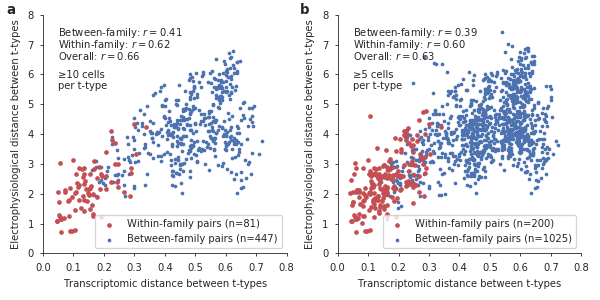

50 t-types quantified


In [7]:
from scipy.spatial.distance import pdist

selection = (ttypes['type']!='') & (m1.exclude=='') & ~np.isnan(np.sum(ephysTransformed,axis=1)) & \
            (ttypes['type'] != 'Sst Chodl') & \
            (ttypes['type'] != 'Pvalb Vipr2_2')

meanTypePhenotype = np.zeros((clusterN, ephysTransformed.shape[1])) * np.nan

for c in range(clusterN):
    ind = selection & (ttypes['type'] == clusterNames[c])
    if np.sum(ind) >= 10:
        meanTypePhenotype[c,:] = np.mean(ephysTransformed[ind,:], axis=0)

m1data = pickle.load(open('../data/processed/reduced-allen-data/10X_cells_v2_AIBS.pickle', 'rb'))
meanTypeRNA = np.zeros((clusterN, m1data['neurons']['counts'].shape[1])) * np.nan

for c in range(clusterN):
    ind = m1data['neurons']['clusters'] == c
    if np.sum(ind) >= 10:
        meanTypeRNA[c,:] = np.mean(np.log1p(m1data['neurons']['counts'][ind,:]), axis=0)
        
haveinfo = ~np.isnan(meanTypePhenotype[:,0])
print(np.sum(haveinfo), 't-types quantified')

Dt = pdist(meanTypeRNA[haveinfo,:], metric='correlation')
Dph = pdist(meanTypePhenotype[haveinfo,:])

families = [c.split()[0] if ~np.isin(c.split()[0][1],['2','4','5','6']) else c.split()[1][:2] for c in clusterNames ]
families = np.array(families)
families[-5:] = 'CT'
_, families = np.unique(families, return_inverse=True)
Dfam = pdist(families[haveinfo][:,np.newaxis])

fig = plt.figure(figsize=(5,2.5))
plt.subplot(121)
plt.scatter(Dt[Dfam==0],Dph[Dfam==0], s=4, c='r', zorder=2)
plt.scatter(Dt[Dfam>0], Dph[Dfam>0], s=2, c='b')
plt.legend(['Within-family pairs (n={})'.format(np.sum(Dfam==0)), 
            'Between-family pairs (n={})'.format(np.sum(Dfam>0))],
           loc='lower right')
plt.text(.05, 6.5, 'Overall: $r={:.2f}$'.format(np.corrcoef(Dt,Dph)[0,1]))
plt.text(.05, 6.9, 'Within-family: $r={:.2f}$'.format(np.corrcoef(Dt[Dfam==0],Dph[Dfam==0])[0,1]))
plt.text(.05, 7.3, 'Between-family: $r={:.2f}$'.format(np.corrcoef(Dt[Dfam>0],Dph[Dfam>0])[0,1]))
plt.text(.05, 5.5, '≥10 cells\nper t-type')

plt.xlabel('Transcriptomic distance between t-types')
plt.ylabel('Electrophysiological distance between t-types')
plt.xlim([0,.8])
plt.ylim([0,8])

for c in range(clusterN):
    ind = selection & (ttypes['type'] == clusterNames[c])
    if np.sum(ind) >= 5:
        meanTypePhenotype[c,:] = np.mean(ephysTransformed[ind,:], axis=0)

haveinfo = ~np.isnan(meanTypePhenotype[:,0])
print(np.sum(haveinfo), 't-types quantified')
Dt = pdist(meanTypeRNA[haveinfo,:], metric='correlation')
Dph = pdist(meanTypePhenotype[haveinfo,:])
Dfam = pdist(families[haveinfo][:,np.newaxis])

plt.subplot(122)
plt.scatter(Dt[Dfam==0],Dph[Dfam==0], s=4, c='r', zorder=2)
plt.scatter(Dt[Dfam>0], Dph[Dfam>0], s=2, c='b')
plt.legend(['Within-family pairs (n={})'.format(np.sum(Dfam==0)), 
            'Between-family pairs (n={})'.format(np.sum(Dfam>0))],
           loc='lower right')
plt.text(.05, 6.5, 'Overall: $r={:.2f}$'.format(np.corrcoef(Dt,Dph)[0,1]))
plt.text(.05, 6.9, 'Within-family: $r={:.2f}$'.format(np.corrcoef(Dt[Dfam==0],Dph[Dfam==0])[0,1]))
plt.text(.05, 7.3, 'Between-family: $r={:.2f}$'.format(np.corrcoef(Dt[Dfam>0],Dph[Dfam>0])[0,1]))
plt.text(.05, 5.5, '≥5 cells\nper t-type')

plt.xlabel('Transcriptomic distance between t-types')
plt.ylabel('Electrophysiological distance between t-types')
plt.xlim([0,.8])
plt.ylim([0,8])

fig.text(.01, .99, 'a', fontsize=8, fontweight='bold', va='top')
fig.text(.5,  .99, 'b', fontsize=8, fontweight='bold', va='top')

sns.despine()
plt.tight_layout()

plt.savefig('../figures/suppfigures/pooled-families.png', dpi=300)
plt.savefig('../figures/suppfigures/pdf/pooled-families.pdf')

<IPython.core.display.Javascript object>


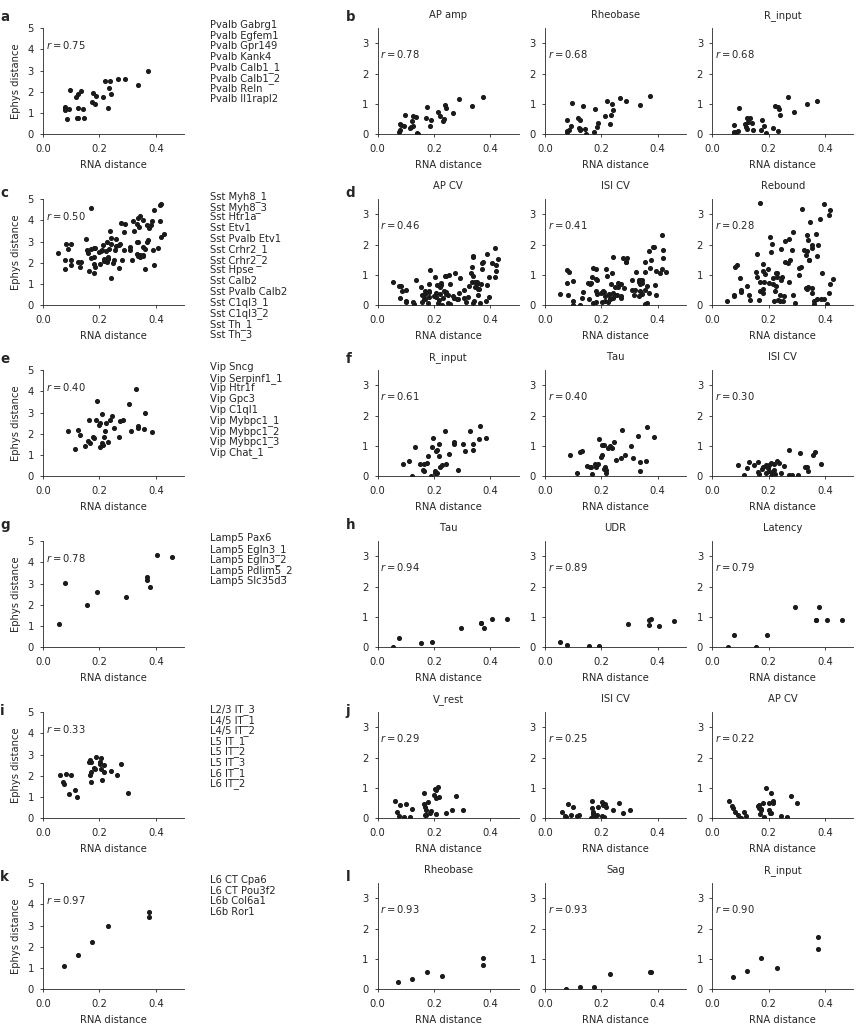

In [9]:
from scipy.spatial.distance import pdist

fig = plt.figure(figsize=(7.2, 7.2/5*6))

ephysLeft = ~np.isin(m1.ephysNames, ephys_features_exclude)

for row,fam in enumerate(['Pvalb','Sst','Vip','Lamp5','IT','CT']):

    selection = (ttypes['family']==fam) & (m1.exclude=='') & \
                ~np.isnan(np.sum(m1.ephys[:, ephysLeft], axis=1)) & \
                (ttypes['type'] != 'Sst Chodl') & \
                (ttypes['type'] != 'Pvalb Vipr2_2')
    
    if fam in ['Pvalb', 'Sst']:
        order = 'pvsst'
    elif fam in ['Vip', 'Lamp5']:
        order = 'viplamp'
    else:
        order = 'exc'

    meanTypePhenotype = np.zeros((clusterN, ephysTransformed.shape[1])) * np.nan
    for c in range(clusterN):
        ind = selection & (ttypes['type'] == clusterNames[c])
        if np.sum(ind) >= 5:
            meanTypePhenotype[c,:] = np.mean(ephysTransformed[ind,:], axis=0)
                    
    meanTypeRNA = np.zeros((clusterN, m1data[order]['counts'].shape[1])) * np.nan
    for c in range(clusterN):
        ind = m1data[order]['clusters'] == c
        if np.sum(ind) >= 10:
            meanTypeRNA[c,:] = np.mean(np.log1p(m1data[order]['counts'][ind,:]), axis=0)
        
    haveinfo = ~np.isnan(meanTypePhenotype[:,0])

    Dt = pdist(meanTypeRNA[haveinfo,:], metric='correlation')
    Dph = pdist(meanTypePhenotype[haveinfo,:])
    ax = plt.subplot(6,5,row*5+1)
    plt.scatter(Dt, Dph, color='k', s=5)
    plt.xlim([0,0.5])
    plt.xlabel('RNA distance')
    plt.ylabel('Ephys distance')
    plt.ylim([0,5])
    plt.text(.01,4,'$r={:.2f}$'.format(scipy.stats.pearsonr(Dt,Dph)[0]))
    sns.despine(ax=ax)
    
    ax = plt.subplot(6,5,row*5+2)
    for t,i in enumerate(np.where(haveinfo)[0]):
        plt.text(0,10-t,clusterNames[i])
    plt.ylim([0, 10])
    sns.despine(ax=ax, bottom=True, left=True)
    plt.xticks([])
    plt.yticks([])
    
    keptFeatures = m1.ephysNames[~np.isin(m1.ephysNames,ephys_features_exclude)]
    corrs = np.zeros(keptFeatures.size)

    for i in range(meanTypePhenotype.shape[1]):
        Dph = pdist(meanTypePhenotype[haveinfo,:][:,i][:,np.newaxis])
        corrs[i] = scipy.stats.pearsonr(Dt,Dph)[0]

    for col,i in enumerate(np.argsort(np.abs(corrs))[::-1][:3]):
        ax = plt.subplot(6,5,row*5+3+col)
        Dph = pdist(meanTypePhenotype[haveinfo,:][:,i][:,np.newaxis])
        plt.scatter(Dt, Dph, color='k', s=5)
        plt.xlim([0,0.5])
        plt.ylim([0,3.5])
        plt.xlabel('RNA distance')
        plt.title(shortEphysLabels[keptFeatures[i]])
        plt.text(.01,2.5,'$r={:.2f}$'.format(corrs[i]))
        sns.despine(ax=ax)
        
plt.tight_layout()

fig.text(0, .99, 'a', fontsize=8, fontweight='bold', va='top')
fig.text(0, .82, 'c', fontsize=8, fontweight='bold', va='top')
fig.text(0, .66, 'e', fontsize=8, fontweight='bold', va='top')
fig.text(0, .50, 'g', fontsize=8, fontweight='bold', va='top')
fig.text(0, .32, 'i', fontsize=8, fontweight='bold', va='top')
fig.text(0, .16, 'k', fontsize=8, fontweight='bold', va='top')

fig.text(.4, .99, 'b', fontsize=8, fontweight='bold', va='top')
fig.text(.4, .82, 'd', fontsize=8, fontweight='bold', va='top')
fig.text(.4, .66, 'f', fontsize=8, fontweight='bold', va='top')
fig.text(.4, .50, 'h', fontsize=8, fontweight='bold', va='top')
fig.text(.4, .32, 'j', fontsize=8, fontweight='bold', va='top')
fig.text(.4, .16, 'l', fontsize=8, fontweight='bold', va='top')

plt.savefig('../figures/suppfigures/all-families.png', dpi=300)
plt.savefig('../figures/suppfigures/pdf/all-families.pdf')

## Assemble main figure

<IPython.core.display.Javascript object>


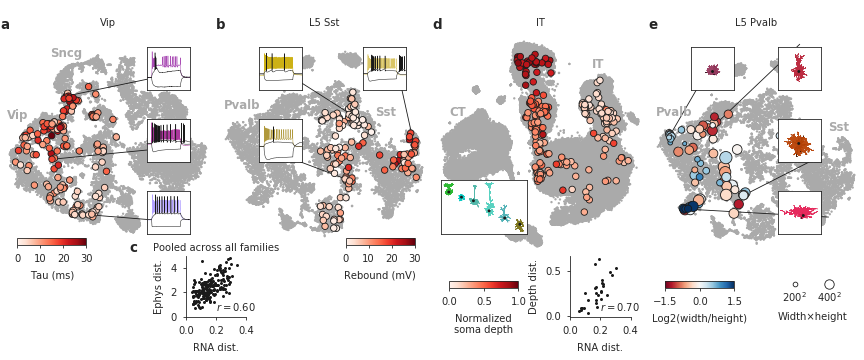

In [10]:
fig = plt.figure(figsize=(7.2,3))

ax_vip  = plt.axes([0,.3,.25,.6])
ax_sst = plt.axes([.25,.3,.25,.6])
ax_it = plt.axes([.5,.3,.25,.6])
ax_pv  = plt.axes([.75,.3,.25,.6])

ax_vip_cbr  = plt.axes([.02,.32,.08,.02])
# ax_sst_cbr = plt.axes([.25+.02,.2,.08,.02])
ax_sst_cbr = plt.axes([.4,.32,.08,.02])
ax_it_cbr = plt.axes([.5+.02,.2,.08,.02])
ax_pv_cbr  = plt.axes([.75+.02,.2,.08,.02])

ax_pv_leg  = plt.axes([.88,.06,.12,.2])

# ax_vip_scatter  = plt.axes([.16, .12, .07, .17])
# ax_sst_scatter = plt.axes([.25+.16, .12, .07, .17])
ax_pooled_scatter = plt.axes([.215, .12, .07, .17])
ax_it_scatter = plt.axes([.5+.16, .12, .07, .17])

ax_it_examples = plt.axes([.51,.35,.1,.15])

ax_vip_example1 = plt.axes([.17,.75,.05,.12])
ax_vip_example2 = plt.axes([.17,.55,.05,.12])
ax_vip_example3 = plt.axes([.17,.35,.05,.12])

ax_sst_example1 = plt.axes([.42,.75,.05,.12])
ax_sst_example2 = plt.axes([.30,.75,.05,.12])
ax_sst_example3 = plt.axes([.30,.55,.05,.12])

ax_pv_example1 = plt.axes([.8,.75,.05,.12])
ax_pv_example2 = plt.axes([.9,.75,.05,.12])
ax_pv_example3 = plt.axes([.9,.55,.05,.12])
ax_pv_example4 = plt.axes([.9,.35,.05,.12])

fig.text(0, .95, 'a', fontsize=8, fontweight='bold', va='top')
fig.text(.25, .95, 'b', fontsize=8, fontweight='bold', va='top')
fig.text(.15, .33, 'c', fontsize=8, fontweight='bold', va='top')
fig.text(.5, .95, 'd', fontsize=8, fontweight='bold', va='top')
fig.text(.75, .95, 'e', fontsize=8, fontweight='bold', va='top');

In [11]:
from scipy.spatial.distance import pdist

selection = (ttypes['type']!='') & (m1.exclude=='') & ~np.isnan(np.sum(ephysTransformed,axis=1)) &\
            (ttypes['type'] != 'Sst Chodl') & (ttypes['type'] != 'Pvalb Vipr2_2')

meanTypePhenotype = np.zeros((clusterN, ephysTransformed.shape[1])) * np.nan

for c in range(clusterN):
    ind = selection & (ttypes['type'] == clusterNames[c])
    if np.sum(ind) >= 5:
        meanTypePhenotype[c,:] = np.mean(ephysTransformed[ind,:], axis=0)

m1data = pickle.load(open('../data/processed/reduced-allen-data/10X_cells_v2_AIBS.pickle', 'rb'))
meanTypeRNA = np.zeros((clusterN, m1data['neurons']['counts'].shape[1])) * np.nan

for c in range(clusterN):
    ind = m1data['neurons']['clusters'] == c
    if np.sum(ind) >= 10:
        meanTypeRNA[c,:] = np.mean(np.log1p(m1data['neurons']['counts'][ind,:]), axis=0)
        
haveinfo = ~np.isnan(meanTypePhenotype[:,0])
print(np.sum(haveinfo), 't-types quantified')

Dt = pdist(meanTypeRNA[haveinfo,:], metric='correlation')
Dph = pdist(meanTypePhenotype[haveinfo,:])

families = [c.split()[0] if ~np.isin(c.split()[0][1],['2','4','5','6']) else c.split()[1][:2] for c in clusterNames ]
families = np.array(families)
families[-5:] = 'CT'
_, families = np.unique(families, return_inverse=True)
Dfam = pdist(families[haveinfo][:,np.newaxis])

plt.sca(ax_pooled_scatter)
plt.scatter(Dt[Dfam==0],Dph[Dfam==0], s=1, c='k')
plt.text(.5, .1, '$r={:.2f}$'.format(np.corrcoef(Dt[Dfam==0],Dph[Dfam==0])[0,1]), 
         transform=ax_pooled_scatter.transAxes, fontsize=6)
sns.despine(ax=ax_pooled_scatter)
plt.xlabel('RNA dist.')
plt.ylabel('Ephys dist.')
plt.xlim([0,0.4])
plt.xticks([0,.2,.4])
plt.ylim([0,5])

# plt.plot([-.55,.95],[6.2,6.2], clip_on=False, linewidth=.5, color='k')
plt.ylim([0,5])
plt.text(.2,5.4,'Pooled across all families', ha='center')

print(scipy.stats.pearsonr(Dt,Dph))

50 t-types quantified
(0.6327726166715801, 5.2266050096904446e-138)


In [12]:
selection = (ttypes['family']=='IT') & (m1.exclude=='')
family = 'exc'
print(np.sum(selection))

Z = pickle.load(open('../data/processed/rnaseq/10x-tsne-' + family + '.pickle', 'rb'))
m1data = pickle.load(open('../data/processed/reduced-allen-data/10X_cells_v2_AIBS.pickle', 'rb'))
pos = rnaseqTools.map_to_tsne(m1data[family]['counts'], m1data[family]['genes'],
                              m1.exonCounts[selection,:], m1.genes, Z, knn=10,
                              newIntronCounts=m1.intronCounts[selection,:], 
                              newExonLengths=m1.exonLengths, newIntronLengths=m1.intronLengths,
                              normalizeNew=True, normalizeReference=False)
col = m1.depth[selection]/m1.thickness[selection]

plt.sca(ax_it)
plt.axis('equal')
plt.scatter(Z[:,0], Z[:,1], s=2, edgecolor='none', c='#aaaaaa', rasterized=True)
plt.text(30, 50, 'IT', color='#aaaaaa', fontsize=7, fontweight='bold')
plt.text(-60, 20,'CT', color='#aaaaaa', fontsize=7, fontweight='bold')
plt.scatter(pos[pos[:,0]>-25,0], 
            pos[pos[:,0]>-25,1], edgecolor='k', linewidth=.5, 
            c=col[pos[:,0]>-25], cmap='Reds', s=15, vmin=0, vmax=1)
plt.title('IT')
plt.xticks([])
plt.yticks([])
sns.despine(ax=ax_it, left=True, bottom=True)

plt.colorbar(label='Normalized\nsoma depth', orientation='horizontal', cax=ax_it_cbr);

250
Using a common set of 478 genes.


In [13]:
from scipy.spatial.distance import pdist

meanTypePhenotype = np.zeros(clusterN) * np.nan

for c in range(clusterN):
    ind = selection & (ttypes['type'] == clusterNames[c]) & ~np.isnan(m1.depth)
    if np.sum(ind) >= 5:
        meanTypePhenotype[c] = np.nanmean(m1.depth[ind]/m1.thickness[ind], axis=0)
              
meanTypeRNA = np.zeros((clusterN, m1data[family]['counts'].shape[1])) * np.nan

for c in range(clusterN):
    ind = m1data[family]['clusters'] == c
    if np.sum(ind) >= 10:
        meanTypeRNA[c,:] = np.mean(np.log1p(m1data[family]['counts'][ind,:]), axis=0)
        
haveinfo = ~np.isnan(meanTypePhenotype)
print(np.sum(haveinfo))

Dt = pdist(meanTypeRNA[haveinfo,:], metric='correlation')
Dph = pdist(meanTypePhenotype[haveinfo][:,np.newaxis])

plt.sca(ax_it_scatter)
plt.scatter(Dt,Dph, s=1, c='k')
plt.text(.5, .1, '$r={:.2f}$'.format(np.corrcoef(Dt,Dph)[0,1]), 
         transform=ax_it_scatter.transAxes, fontsize=6)
sns.despine(ax=ax_it_scatter)
plt.xlabel('RNA dist.')
plt.ylabel('Depth dist.')
plt.yticks([0,.5])
plt.xlim([0,0.4])
plt.xticks([0,.2,.4])

print(scipy.stats.pearsonr(Dt,Dph))

8
(0.6983523652197973, 3.5891504956688055e-05)


In [14]:
offset = 0
plt.sca(ax_it_examples)
plt.axis('equal')
for example in [392,1101,209,59,915,760]:
    col = clusterColors[clusterNames==ttypes['type'][example-2]][0]
    ax_col = 'none'
    den_col = col
    w = plot_swc(swcfiles[m1.cells[example-2]], ax=ax_it_examples, 
                 depth=m1.depth[example-2], thickness=m1.thickness[example-2],
             axon_color=ax_col, dendrite_color=den_col, soma_color='none', offset=offset)
    offset += w + .1
plt.xticks([])
plt.yticks([]);

In [15]:
selection = (ttypes['family']=='Vip') & (m1.exclude=='') & \
            ~np.isnan(np.sum(m1.ephys[:, ~np.isin(m1.ephysNames, ephys_features_exclude)], axis=1))
family = 'viplamp'    
print(np.sum(selection))

Z = pickle.load(open('../data/processed/rnaseq//10x-tsne-' + family + '.pickle', 'rb'))
m1data = pickle.load(open('../data/processed/reduced-allen-data/10X_cells_v2_AIBS.pickle', 'rb'))
pos = rnaseqTools.map_to_tsne(m1data[family]['counts'], m1data[family]['genes'],
                              m1.exonCounts[selection,:], m1.genes, Z, knn=10,
                              newIntronCounts=m1.intronCounts[selection,:], 
                              newExonLengths=m1.exonLengths, newIntronLengths=m1.intronLengths,
                              normalizeNew=True, normalizeReference=False)

# col = m1.ephys[selection,:][:, m1.ephysNames=='Rebound (mV)'].squeeze()
col = m1.ephys[selection,:][:, m1.ephysNames=='Membrane time constant (ms)'].squeeze()

plt.sca(ax_vip)
plt.axis('equal')
plt.scatter(Z[:,0], Z[:,1], s=2, edgecolor='none', c='#aaaaaa', rasterized=True)
plt.text(-70, 20, 'Vip',  color='#aaaaaa', fontsize=7, fontweight='bold')
plt.text(-40, 62, 'Sncg', color='#aaaaaa', fontsize=7, fontweight='bold')
plt.scatter(pos[:,0], pos[:,1], edgecolor='k', linewidth=.5, c=col, cmap='Reds', s=15, 
            vmin=0, vmax=30, zorder=2)
plt.title('Vip')
plt.xticks([])
plt.yticks([])
sns.despine(ax=ax_vip, left=True, bottom=True)

plt.colorbar(label='Tau (ms)', orientation='horizontal', cax=ax_vip_cbr, ticks=[0,10,20,30]);

# for i,num in enumerate(np.where(selection)[0]):
#     plt.text(pos[i,0],pos[i,1],num+2)

153
Using a common set of 490 genes.


In [16]:
for example,ax in zip([192,1139,1053],[ax_vip_example1,ax_vip_example2,ax_vip_example3]):
    col = clusterColors[clusterNames==ttypes['type'][example-2]][0]
    plt.sca(ax)
    time = three_traces[m1.cells[example-2]][:,3]
    traces = three_traces[m1.cells[example-2]][:,:3]
    timeinterval = time<=.9
    time = time[timeinterval]
    traces = traces[timeinterval,:]
    plt.plot(time, traces[:,2], color=col, linewidth=.3, rasterized=True)
    plt.plot(time, traces[:,1], color='k', linewidth=.3, rasterized=True)
    plt.plot(time, traces[:,0], color='k', linewidth=.3, rasterized=True)
    plt.xlim([0,.9])
    plt.ylim([-150,75])
    plt.xticks([])
    plt.yticks([])
    
plt.sca(ax_vip)
i = np.sum(selection[:192-2])
plt.plot([pos[i,0], 40], [pos[i,1], 50], linewidth=.5, color='k', zorder=1)
i = np.sum(selection[:1139-2])
plt.plot([pos[i,0], 40], [pos[i,1], 0], linewidth=.5, color='k', zorder=1)
i = np.sum(selection[:1053-2])
plt.plot([pos[i,0], 40], [pos[i,1], -50], linewidth=.5, color='k', zorder=1);

In [17]:
selection = (ourLayers=='5') & (ttypes['family']=='Sst') & (m1.exclude=='') & \
            ~np.isnan(np.sum(m1.ephys[:, ~np.isin(m1.ephysNames, ephys_features_exclude)], axis=1)) & \
            (ttypes['type'] != 'Sst Chodl')
family = 'pvsst'
print(np.sum(selection))

Z = pickle.load(open('../data/processed/rnaseq/10x-tsne-' + family + '.pickle', 'rb'))
m1data = pickle.load(open('../data/processed/reduced-allen-data/10X_cells_v2_AIBS.pickle', 'rb'))
pos = rnaseqTools.map_to_tsne(m1data[family]['counts'], m1data[family]['genes'],
                              m1.exonCounts[selection,:], m1.genes, Z, knn=10, 
                              newExonLengths=m1.exonLengths, newIntronLengths=m1.intronLengths,
                              normalizeNew=True, normalizeReference=False)

col = m1.ephys[selection,:][:, m1.ephysNames=='Rebound (mV)'].squeeze()

plt.sca(ax_sst)
plt.axis('equal')
plt.scatter(Z[:,0], Z[:,1], s=2, edgecolor='none', c='#aaaaaa', rasterized=True)
plt.text(35, 25,  'Sst',   color='#aaaaaa', fontsize=7, fontweight='bold')
plt.text(-70, 30, 'Pvalb', color='#aaaaaa', fontsize=7, fontweight='bold')
plt.scatter(pos[:,0], pos[:,1], edgecolor='k', linewidth=.5, c=col, cmap='Reds', 
            s=15, vmin=0, vmax=30, zorder=2)
plt.title('L5 Sst')
plt.xticks([])
plt.yticks([])
sns.despine(ax=ax_sst, left=True, bottom=True)

plt.colorbar(label='Rebound (mV)', orientation='horizontal', cax=ax_sst_cbr, ticks=[0,10,20,30]);

# for i,num in enumerate(np.where(selection)[0]):
#     plt.text(pos[i,0],pos[i,1],num+2)

143
Using a common set of 493 genes.


In [18]:
for example,ax in zip([456,414,580],[ax_sst_example1,ax_sst_example2,ax_sst_example3]):
    col = clusterColors[clusterNames==ttypes['type'][example-2]][0]
    plt.sca(ax)
    time = three_traces[m1.cells[example-2]][:,3]
    traces = three_traces[m1.cells[example-2]][:,:3]
    timeinterval = time<=.9
    time = time[timeinterval]
    traces = traces[timeinterval,:]
    plt.plot(time, traces[:,2], color=col, linewidth=.3, rasterized=True)
    plt.plot(time, traces[:,1], color='k', linewidth=.3, rasterized=True)
    plt.plot(time, traces[:,0], color='k', linewidth=.3, rasterized=True)
    plt.xlim([0,.9])
    plt.ylim([-150,75])
    plt.xticks([])
    plt.yticks([])
    
plt.sca(ax_sst)
i = np.sum(selection[:456-2])
plt.plot([pos[i,0], 50], [pos[i,1], 60], linewidth=.5, color='k', zorder=1)
i = np.sum(selection[:414-2])
plt.plot([pos[i,0], -35], [pos[i,1], 60], linewidth=.5, color='k', zorder=1)
i = np.sum(selection[:580-2])
plt.plot([pos[i,0], -35], [pos[i,1], 0], linewidth=.5, color='k', zorder=1);

In [19]:
selection = (ourLayers=='5') & (ttypes['family']=='Pvalb') & (m1.exclude=='') & \
            ~np.isnan(m1.morphometrics[:,m1.morphometricsNames=='axon width'].squeeze()) & \
            (ttypes['type'] != 'Pvalb Vipr2_2')
family = 'pvsst'
print(np.sum(selection))

Z = pickle.load(open('../data/processed/rnaseq//10x-tsne-' + family + '.pickle', 'rb'))
m1data = pickle.load(open('../data/processed/reduced-allen-data/10X_cells_v2_AIBS.pickle', 'rb'))
pos = rnaseqTools.map_to_tsne(m1data[family]['counts'], m1data[family]['genes'],
                              m1.exonCounts[selection,:], m1.genes, Z, knn=10, 
                              newExonLengths=m1.exonLengths, newIntronLengths=m1.intronLengths,
                              normalizeNew=True, normalizeReference=False)

col = np.log2(m1.morphometrics[selection,:][:, m1.morphometricsNames=='axon robust width'].squeeze()/
              m1.morphometrics[selection,:][:, m1.morphometricsNames=='axon robust height'].squeeze())

size = (m1.morphometrics[selection,:][:, m1.morphometricsNames=='axon robust width'].squeeze()*
              m1.morphometrics[selection,:][:, m1.morphometricsNames=='axon robust height'].squeeze())

plt.sca(ax_pv)
plt.axis('equal')
plt.scatter(Z[:,0], Z[:,1], s=2, edgecolor='none', c='#aaaaaa', rasterized=True)
plt.text(50, 20,  'Sst',   color='#aaaaaa', fontsize=7, fontweight='bold')
plt.text(-70, 30, 'Pvalb', color='#aaaaaa', fontsize=7, fontweight='bold')
plt.scatter(pos[abs(col)<=1.2,0], pos[abs(col)<=1.2,1], edgecolor='k', linewidth=.5, c=col[abs(col)<=1.2], 
            cmap='RdBu', vmin=-1.5, vmax=1.5, s=size[abs(col)<=1.2]/5000, zorder=3)
plt.scatter(pos[abs(col)>1.2,0], pos[abs(col)>1.2,1], edgecolor='k', linewidth=.5, c=col[abs(col)>1.2], 
            cmap='RdBu', vmin=-1.5, vmax=1.5, s=size[abs(col)>1.2]/5000, zorder=3)
plt.title('L5 Pvalb')
plt.xticks([])
plt.yticks([])
sns.despine(ax=ax_pv, left=True, bottom=True)

plt.colorbar(label='Log2(width/height)', orientation='horizontal', cax=ax_pv_cbr, ticks=[-1.5,0,1.5]);

# for i,num in enumerate(np.where(selection)[0]):
#     plt.text(pos[i,0],pos[i,1],num+2)

plt.sca(ax_pv_leg)
plt.scatter(0,0, edgecolor='k', linewidth=.5, c='w', cmap='RdBu', vmin=-1.5, vmax=1.5, s=40000/5000)
plt.scatter(1,0, edgecolor='k', linewidth=.5, c='w', cmap='RdBu', vmin=-1.5, vmax=1.5, s=160000/5000)
plt.text(0,-1,'$200^2$', fontsize=6, ha='center')
plt.text(1,-1,'$400^2$', fontsize=6, ha='center')
plt.text(.5,-2,'Width×height', fontsize=6, ha='center')
plt.xlim([-1,2])
plt.ylim([-3,1])
plt.xticks([])
plt.yticks([])
sns.despine(ax=ax_pv_leg, left=True, bottom=True)

76
Using a common set of 493 genes.


In [20]:
for example,ax in zip([315,388,1282,126],[ax_pv_example1,ax_pv_example2,ax_pv_example3,ax_pv_example4]):
    col = clusterColors[clusterNames==ttypes['type'][example-2]][0]
    ax_col = col
    den_col = [adjust_lightness(col,.4)]
    plt.sca(ax)
    plot_swc(swcfiles[m1.cells[example-2]], ax=ax, depth=m1.depth[example-2], thickness=m1.thickness[example-2],
             axon_color=ax_col, dendrite_color=den_col, soma_color='none', minwidth=.65)
    plt.xlim([-.05,.7])
    plt.ylim(-m1.depth[example-2]/m1.thickness[example-2] + np.array([-.3,.4]))
    plt.xticks([])
    plt.yticks([])
    
plt.sca(ax_pv)
i = np.sum(selection[:315-2])
plt.plot([pos[i,0], -35], [pos[i,1], 60], linewidth=.5, color='k', zorder=1)
i = np.sum(selection[:388-2])
plt.plot([pos[i,0], 30], [pos[i,1], 80], linewidth=.5, color='k', zorder=1)
i = np.sum(selection[:1282-2])
plt.plot([pos[i,0], 40], [pos[i,1], 0], linewidth=.5, color='k', zorder=1)
i = np.sum(selection[:126-2])
plt.plot([pos[i,0], 50], [pos[i,1], -40], linewidth=.5, color='k', zorder=1);

In [21]:
bbox =  matplotlib.transforms.Bbox([[0,0.06],[7.2,2.86]])

plt.savefig('../figures/mainfigures/families.png', dpi=300, bbox_inches=bbox)
plt.savefig('../figures/mainfigures/pdf/families_dpi300.pdf', dpi=300, bbox_inches=bbox)
plt.savefig('../figures/mainfigures/pdf/families_dpi600.pdf', dpi=600, bbox_inches=bbox)